In [78]:
using Test 
using Profile
using ProfileView
using Revise
using DataStructures
using BenchmarkTools

In [79]:
include("src/FEFMM.jl")

Main.FEFMM

In [80]:
κ2 = ones(101,101,101)
dx = [0.1,0.1,0.1]
x0 = CartesianIndex(1,1,1)
τa3d = zeros(101,101,101)
τaxis = 0:0.1:10
for k in 1:101
    for j in 1:101
        for i in 1:101
            τa3d[i,j,k] = sqrt(τaxis[i]^2+τaxis[j]^2+τaxis[k]^2)
        end
    end
end

In [81]:
R = Float64
N = 3

3

In [82]:
ordering = Array{Int}(undef, length(κ2))
cs = FEFMM.cartstrides(κ2)
inds = CartesianIndices(κ2)
I1 = first(inds)
Iend = last(inds)
τ0 = ones(R, size(κ2))
FEFMM.mul_analytic!(τ0, dx..., size(κ2)..., Tuple(x0)...)
∇τ0 = FEFMM.grad_analytic(τ0, dx..., size(κ2)..., Tuple(x0)...)
τ1 = Inf.*ones(R, size(κ2))
τ1[x0] = κ2[x0]
tags = ones(UInt8,size(κ2))
tags[x0] = 0x2
α = Array{R}(undef,length(size(τ1)))
β = similar(α)
LI = LinearIndices(τ1)
xn = Array{typeof(I1)}(undef, N*2)

6-element Array{CartesianIndex{3},1}:
 CartesianIndex(4654250704, 4654250736, 4654250768)
 CartesianIndex(4654250800, 4654250832, 4654250864)
 CartesianIndex(4654210160, 4654250896, 4654210176)
 CartesianIndex(4654210192, 4654210208, 4654210224)
 CartesianIndex(4654250928, 4654210272, 4654250992)
 CartesianIndex(4654251024, 4654251056, 32034)     

In [83]:
@btime FEFMM.grad_analytic(τ0, dx[1],dx[2],dx[3],101,101,101, 1,1,1)

  6.753 ms (10 allocations: 23.58 MiB)


3-element Array{Array{Float64,3},1}:
 [NaN 0.0 … 0.0 0.0; 1.0 0.57735 … 0.00714231 0.00707089; … ; 1.0 0.999898 … 0.57735 0.573482; 1.0 0.9999 … 0.581219 0.57735]

[NaN 0.0 … 0.0 0.0; 1.0 0.57735 … 0.00714231 0.00707089; … ; 1.0 0.999898 … 0.57735 0.573482; 1.0 0.9999 … 0.581219 0.57735]

[NaN 0.0 … 0.0 0.0; 1.0 0.57735 … 0.00714231 0.00707089; … ; 1.0 0.999898 … 0.57735 0.573482; 1.0 0.9999 … 0.581219 0.57735]

...

[NaN 0.0 … 0.0 0.0; 1.0 0.57735 … 0.00714231 0.00707089; … ; 1.0 0.999898 … 0.57735 0.573482; 1.0 0.9999 … 0.581219 0.57735]

[NaN 0.0 … 0.0 0.0; 1.0 0.57735 … 0.00714231 0.00707089; … ; 1.0 0.999898 … 0.57735 0.573482; 1.0 0.9999 … 0.581219 0.57735]

[NaN 0.0 … 0.0 0.0; 1.0 0.57735 … 0.00714231 0.00707089; … ; 1.0 0.999898 … 0.57735 0.573482; 1.0 0.9999 … 0.581219 0.57735]                                                                  
 [NaN 0.707107 … 0.707107 0.707107; 0.0 0.57735 … 0.707089 0.707089; … ; 0.0 0.0101 … 0.57735 0.579275; 0.0 0.009999 … 0.575406 0.57735]

In [84]:
front = BinaryMinHeap{FEFMM.Node{R}}()
push!(front, FEFMM.Node(inds[x0], τ1[x0]*τ0[x0])) 

BinaryHeap{Main.FEFMM.Node{Float64,N} where N,DataStructures.LessThan}(DataStructures.LessThan(), Main.FEFMM.Node{Float64,N} where N[Node{Float64,3}(CartesianIndex(1, 1, 1), 0.0)])

In [85]:
front

BinaryHeap{Main.FEFMM.Node{Float64,N} where N,DataStructures.LessThan}(DataStructures.LessThan(), Main.FEFMM.Node{Float64,N} where N[Node{Float64,3}(CartesianIndex(1, 1, 1), 0.0)])

In [86]:
ocount = 1
x = pop!(front).ind
ordering[ocount] = LI[x]
ocount += 1
tags[x] = 0x3
FEFMM.set_neighbours!(xn, x, tags, cs, I1, Iend)

In [87]:
y = xn[2]

CartesianIndex(2, 1, 1)

In [88]:
@btime FEFMM.solve_node(τ1, α, β, τ0, ∇τ0, tags, κ2, CartesianIndex(2,1,1), dx, cs, I1, Iend)

  78.771 ns (1 allocation: 16 bytes)


1.0

In [89]:
Profile.clear()

In [90]:
@profile for i = 1:1000000
    FEFMM.solve_node(τ1, α, β, τ0, ∇τ0, tags, κ2, CartesianIndex(2,1,1), dx, cs, I1, Iend)
end

In [91]:
Profile.print()

71 ./task.jl:259; (::getfield(IJulia, Symbol("##15#18...
 71 .../GIANC/src/eventloop.jl:8; eventloop(::ZMQ.Socket)
  71 ./essentials.jl:741; invokelatest
   71 ./essentials.jl:742; #invokelatest#1
    71 ...rc/execute_request.jl:67; execute_request(::ZMQ.Socket, ::I...
     71 ...c/SoftGlobalScope.jl:218; softscope_include_string(::Modul...
      71 ./boot.jl:328; eval
       71 ./In[90]:1; top-level scope
        71 ...file/src/Profile.jl:25; macro expansion
         71 ./In[90]:2; macro expansion
          4  ...ctoredeikonalfmm.jl:14; solve_node(::Array{Float64,3},...
           4 ./iterators.jl:138; iterate
            4 ./iterators.jl:139; iterate
             4 ./array.jl:705; iterate
              4 ./array.jl:705; iterate
               4 ./array.jl:729; getindex
          19 ...ctoredeikonalfmm.jl:15; solve_node(::Array{Float64,3},...
           1  ...eighbour_checks.jl:0; check1fwd(::Array{Float64,3},...
           17 ...eighbour_checks.jl:44; check1fwd(::Array{Float64,3},...

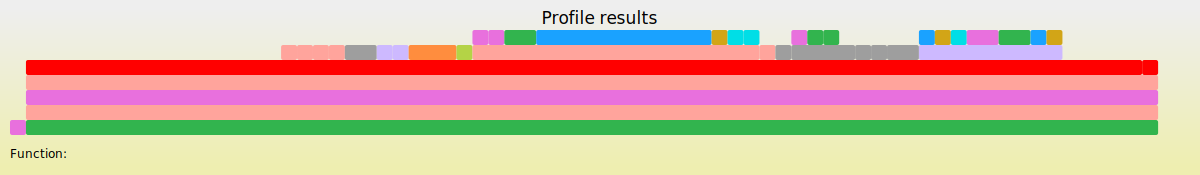

In [92]:
ProfileView.view()

In [93]:
@code_llvm FEFMM.solve_node(τ1, α, β, τ0, ∇τ0, tags, κ2, CartesianIndex(2,1,1), dx, cs, I1, Iend)


;  @ /Users/jackbmuir/Documents/Code/FEFMM/src/factoredeikonalfmm.jl:14 within `solve_node'
define double @julia_solve_node_13880(%jl_value_t addrspace(10)* nonnull align 16 dereferenceable(40), %jl_value_t addrspace(10)* nonnull align 16 dereferenceable(40), %jl_value_t addrspace(10)* nonnull align 16 dereferenceable(40), %jl_value_t addrspace(10)* nonnull align 16 dereferenceable(40), %jl_value_t addrspace(10)* nonnull align 16 dereferenceable(40), %jl_value_t addrspace(10)* nonnull align 16 dereferenceable(40), %jl_value_t addrspace(10)* nonnull align 16 dereferenceable(40), { [3 x i64] } addrspace(11)* nocapture nonnull readonly dereferenceable(24), %jl_value_t addrspace(10)* nonnull align 16 dereferenceable(40), %jl_value_t addrspace(10)* nonnull align 16 dereferenceable(40), { [3 x i64] } addrspace(11)* nocapture nonnull readonly dereferenceable(24), { [3 x i64] } addrspace(11)* nocapture nonnull readonly dereferenceable(24)) {
top:
  %12 = alloca { [3 x i64] }, align 8
; ┌ @ it

In [94]:
    function const_k2(h)
        #Define Medium
        a = -0.4
        s0 = 2.0
        #Set up grid
        X = 0.0:h:8.0
        Y = 0.0:h:4.0
        sx = 4.0
        sy = 0.0 
        sxi = findfirst(x->x==sx, X)
        syi = findfirst(y->y==sy, Y)
        x0 = CartesianIndex(syi, sxi)
        dist2 = ((X.-sx)').^2 .+ ((Y.-sy)).^2
        depth = 0.0*(X.-sx)'.+(Y.-sy)
        k2 = s0^2 .+ 2*a*depth
        Sb2 = s0^2 .+ a*depth
        sig2 = 2*dist2./(Sb2.+sqrt.(Sb2.^2 .- a*a*dist2))
        t_exact = Sb2.*sqrt.(sig2) .- a*a*sqrt.(sig2).^3 ./ 6
        (x0, k2, t_exact)
    end

    function const_v2(h)
        #Define Medium
        a = 1.0
        s0 = 2.0
        #Set up grid
        X = 0.0:h:8.0
        Y = 0.0:h:4.0
        sx = 4.0
        sy = 0.0 
        sxi = findfirst(x->x==sx, X)
        syi = findfirst(y->y==sy, Y)
        x0 = CartesianIndex(syi, sxi)
        dist2 = ((X.-sx)').^2 .+ ((Y.-sy)).^2
        depth = 0.0*(X.-sx)'.+(Y.-sy)
        k = 1 ./ (1/s0 .+ a*depth)

        t_exact = @. 1/a*acosh(1+1/2*s0*a*a*k*dist2)
        (x0, k.^2, t_exact)
    end

const_v2 (generic function with 1 method)

In [95]:
h = 1/40
(x0, k2, t_exact) = const_k2(h)
(t_pred, ordering) = FEFMM.fefmm(k2, [h,h], x0)
Profile.clear()  # in case we have any previous profiling data
h = 1/320
(x0, k2, t_exact) = const_k2(h)
@time FEFMM.fefmm(k2, [h,h], x0)
@profile FEFMM.fefmm(k2, [h,h], x0)

  1.394906 seconds (65 allocations: 178.712 MiB, 5.45% gc time)


([7.94694 7.94082 … 7.94082 7.94694; 7.94567 7.93955 … 7.93955 7.94567; … ; 8.35076 8.34796 … 8.34796 8.35076; 8.35076 8.34797 … 8.34797 8.35076], [1639681, 1639682, 1640962, 1638400, 1640963, 1638401, 1639683, 1642243, 1637119, 1638402  …  3280637, 1277, 1278, 3280638, 1279, 3280639, 1280, 3280640, 1281, 3280641])

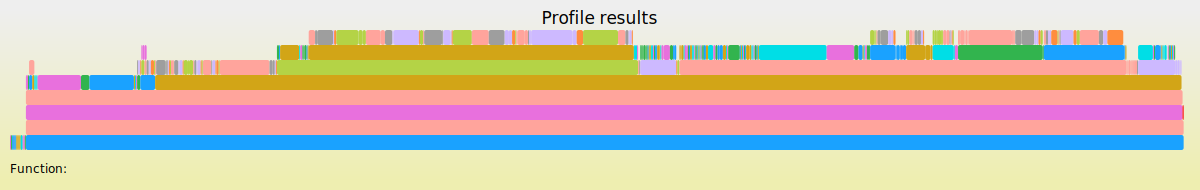

In [96]:
ProfileView.view()

In [40]:
R = Float64
N = 2
h = 1/320
(xs, κ2, t_exact) = const_k2(h)
dx = [h,h]
#initialization
ordering = Array{Int}(undef, length(κ2)) 
cs = FEFMM.cartstrides(κ2) 
inds = CartesianIndices(κ2) 
I1 = first(inds)
Iend = last(inds)
τ0 = ones(R, size(κ2))
FEFMM.mul_analytic!(τ0, dx..., size(κ2)..., Tuple(xs)...)
∇τ0 = FEFMM.grad_analytic(τ0, dx..., size(κ2)..., Tuple(xs)...)
τ1 = Inf.*ones(R, size(κ2))
τ1[xs] = κ2[xs]
tags = ones(UInt8,size(κ2))
tags[xs] = 0x2
front = BinaryMinHeap{FEFMM.Node{R,N}}()
push!(front, FEFMM.Node(inds[xs], τ1[xs]*τ0[xs])) 
α = Array{R}(undef,length(size(τ1)))
β = similar(α)
LI = LinearIndices(τ1)
xn = Array{typeof(I1)}(undef, N*2)

4-element Array{CartesianIndex{2},1}:
 CartesianIndex(8295695626213276268, 7237124482210884719)
 CartesianIndex(7161117171973169253, 7739828916486041460)
 CartesianIndex(3345450384878562927, 232787700842)       
 CartesianIndex(0, 0)                                    

In [41]:
Profile.clear()  # in case we have any previous profiling data
@profile FEFMM.fefmm_loop!(τ1, 1, ordering, α, β, τ0, ∇τ0, tags, front, κ2, dx, cs, xn, I1, Iend, LI)

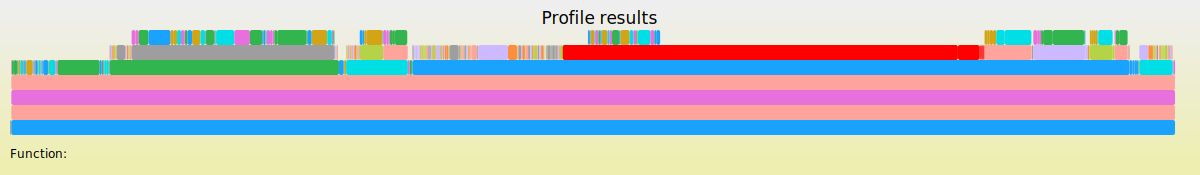

In [42]:
ProfileView.view()

In [20]:
@time             FEFMM.solve_node(τ1, α, β, τ0, ∇τ0, tags, κ2, CartesianIndex(1,1), dx, cs, I1, Iend)


  0.000014 seconds (14 allocations: 352 bytes)


1.9867346939844124